In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

%load_ext autoreload
%autoreload 2

In [2]:
########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Display balls

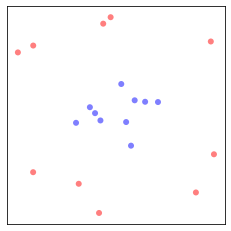

In [13]:

from experiments.dataloaders import ConcentricSphere
from torch.utils.data import DataLoader
from viz.plots import single_feature_plt

# Create training data in 2D, consisting of a concentric disk and an annulus
data_dim = 2
data_concentric = ConcentricSphere(data_dim, inner_range=(0., .5), outer_range=(1., 1.5), 
                                   num_points_inner=10, num_points_outer=10)
dataloader = DataLoader(data_concentric, batch_size=2, shuffle=True)

# Visualize a batch of data (use a large batch size for visualization)
dataloader_viz = DataLoader(data_concentric, batch_size=100, shuffle=True)
for inputs, targets in dataloader_viz:
    break
    

single_feature_plt(inputs, targets)

In [8]:
inputs.shape

torch.Size([20, 2])

In [17]:
targets.shape

torch.Size([200, 1])

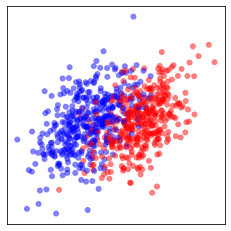

In [50]:
from torch.utils.data import DataLoader
from viz.plots import single_feature_plt
from experiments.dataloaders import GaussianMixture

cov_1 = np.array([[1, 1/2.], [1/2., 1]])
cov_2= np.array([[1, 1/2.], [1/2., 1]])

mean_1 = np.array([0,0])
mean_2 = np.array([2, 0])

num_1 = 400
num_2 = 400


# Create training data in 2D, consisting of a concentric disk and an annulus
data_dim = 2
data_gaussian = GaussianMixture(num_1, num_2, mean_1, mean_2, cov_1, cov_2)

dataloader = DataLoader(data_gaussian, batch_size=10, shuffle=True)

# Visualize a batch of data (use a large batch size for visualization)
dataloader_viz = DataLoader(data_gaussian, batch_size=1000, shuffle=True)
for inputs, targets in dataloader_viz:
    break
    

single_feature_plt(inputs, targets)

In [51]:
import torch.optim as optim

# Get n neural nets and init them
num_nets = 1
tau = 2500 # num batches before resampling
beta = -40

nets = [Net() for _ in range(num_nets)]

nets_weights = np.zeros(num_nets)

#  Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(nets[i].parameters(), lr=0.01, momentum=0) for i in range(num_nets)]

num_epochs = 100

In [52]:
def sample_index_softmax(weights, positions, beta=1):
    probabilities = softmax(weights, beta)
    pos_filter = np.random.choice(list(range(len(positions))), len(positions), p=probabilities)
    return pos_filter

def softmax(weights, beta=-1):
    # normalize weights:
    weights /= np.sum(weights)
    
    sum_exp_weights = sum([np.exp(beta*w) for w in weights])
    probabilities = np.array([np.exp(beta*w) for w in weights]) / sum_exp_weights
    return probabilities

def weight_function(grad, curr_weight):
    input_shape = grad.shape # batch, filters, x_dim, y_dim
    grad = grad.reshape((input_shape[0], np.product(input_shape[1:]))).T

    return curr_weight + np.sum(np.linalg.norm(grad, axis=0))

In [53]:
import copy

########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    running_losses = np.zeros(num_nets)
    
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.reshape(len(labels)).long()
        
        # cycle neural net
        curr_nn_idx = (i % len(nets))
        net = nets[curr_nn_idx]
        optimizer = optimizers[curr_nn_idx]
        
        # Compute gradients for input. 
        inputs.requires_grad = True

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs.float(), labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        
        # zero the parameter gradients + get gradient for inpupt
        optimizer.zero_grad()

        input_grads = []
        output_forb = torch.norm(outputs)
        output_forb.backward()
        input_grads = inputs.grad
        
#         for i in range(len(outputs)):
#             optimizer.zero_grad()
#             outputs[i].backward()
#             input_grads.append([inputs.grad])
#         input_grads = np.array([input_grads])
#         print(input_grads.shape)
        
        # update weights
        nets_weights[curr_nn_idx] = weight_function(input_grads, nets_weights[curr_nn_idx])

        # update statistics
        running_losses[curr_nn_idx] += loss.item()

            
#         # resample particles (if not, do something else potentially)
#         if i % tau == (tau - 1):
#             sampled_idx = sample_index_softmax(nets_weights, nets, beta=0.01)
#             # init nets etc
#             nets = [copy.deepcopy(nets[i]) for i in sampled_idx]
#             optimizers = [optim.SGD(nets[i].parameters(), lr=0.01, momentum=0) for i in range(num_nets)]
#             nets_weights = np.zeros(num_nets)

#             # print statistics 
#             for n_i in range(num_nets):
#                 print('Resampling. [%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_losses[n_i]/float(i % 1000)))
                
#         if i % (50) == (0):
#             for n_i in range(num_nets):
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_losses[n_i]/float(10)))
#                 running_losses[n_i] = 0.0
    if epoch % 100 == 0:     
        # resample particles (if not, do something else potentially)
        sampled_idx = sample_index_softmax(nets_weights, nets, beta=beta)
        # init nets etc
        nets = [copy.deepcopy(nets[i]) for i in sampled_idx]
        optimizers = [optim.SGD(nets[i].parameters(), lr=0.01, momentum=0) for i in range(num_nets)]
        nets_weights = np.zeros(num_nets)




        

print('Finished Training')

########################################################################
# Let's quickly save our trained model:

# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

Finished Training


In [43]:
def get_average_output(nets, inp):
    outs = [net(inp).detach().numpy() for net in nets]
    return np.mean(outs, axis=0)
    

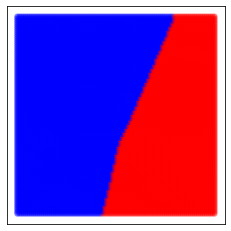

In [54]:
X = np.linspace(-4, 5, 100)
Y = np.linspace(-4, 5, 100)

inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X) * len(Y)).T
inp_t = torch.tensor(inp).float()

outputs = get_average_output(nets, inp_t) #nets[0](inp_t).detach().numpy()
# loss = np.array(criterion(outputs.float(), labels))
out = np.argmax(outputs, axis=1).reshape(len(outputs), 1)
# out = out.reshape(len(X), len(Y))
# out = loss.reshape(len(X), len(Y))

single_feature_plt(inp_t, out)

In [45]:
# print confidence 

X = np.linspace(-4, 5, 100)
Y = np.linspace(-4, 5, 100)

inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X) * len(Y)).T
inp_t = torch.tensor(inp).float()

outputs = get_average_output(nets, inp_t) #nets[0](inp_t).detach().numpy()

# loss = np.array(criterion(outputs.float(), labels))
# out = np.argmax(outputs, axis=1).reshape(len(outputs), 1)
out = np.abs(outputs[:, 0] - outputs[:, 1])
# out = out.reshape(len(X), len(Y))
out = out.reshape(len(X), len(Y))

# single_feature_plt(inp_t, out)

In [55]:
# print confidence 

X = np.linspace(-4, 5, 100)
Y = np.linspace(-4, 5, 100)

inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X) * len(Y)).T
inp_t = torch.tensor(inp).float()

outputs = get_average_output(nets, inp_t) #nets[0](inp_t).detach().numpy()

# loss = np.array(criterion(outputs.float(), labels))
# out = np.argmax(outputs, axis=1).reshape(len(outputs), 1)
out = np.linalg.norm(outputs, axis=1)
# out = out.reshape(len(X), len(Y))
out = out.reshape(len(X), len(Y))

# single_feature_plt(inp_t, out)

In [56]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=out, x=X, y=Y, colorscale="Viridis")])

fig.update_layout(title='Function', autosize=False,
                  width=1000, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()